In [27]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans

import os

In [28]:
num_clusters = 6

# Extract Lab Values

In [29]:
def extract_lab_features(image):
    # Identify black pixels in the original image (RGB values are all zero)
    black_mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) == 0
    # Create an inverse mask for non-black pixels
    non_black_mask = ~black_mask

    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L_channel, A_channel, B_channel = cv2.split(lab_image)

    # Apply the non-black mask to each channel
    L_non_black = L_channel[non_black_mask]
    A_non_black = A_channel[non_black_mask]
    B_non_black = B_channel[non_black_mask]

    if L_non_black.size == 0:
        l_mean = 0
        a_mean = 0
        b_mean = 0
    else:
        l_mean = np.mean(L_non_black)
        a_mean = np.mean(A_non_black)
        b_mean = np.mean(B_non_black)

    return l_mean, a_mean, b_mean

In [30]:
filenames = []
l_values = []
a_values = []
b_values = []

In [31]:
base_image_path = '../dataset_cropped_no_oversaturated/all/'
images = os.listdir(base_image_path)

In [32]:
for image_file in tqdm(images, desc="Parsing images"):
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        full_image_path = os.path.join(base_image_path, image_file)
        image = cv2.imread(full_image_path)
        if image is None:
            print(f"Error: Unable to read image at {full_image_path}")
            continue
        
        l_mean, a_mean, b_mean = extract_lab_features(image)
        
        filenames.append(full_image_path)
        l_values.append(l_mean)
        a_values.append(a_mean)
        b_values.append(b_mean)

Parsing images: 100%|██████████| 1055/1055 [00:08<00:00, 118.11it/s]


In [33]:
df = pd.DataFrame({
    'filename': filenames,
    'L': l_values,
    'A': a_values,
    'B': b_values
})

In [34]:
overall_L_mean = df['L'].mean()

# K-Means Clustering

In [35]:
X = df[['A', 'B']]
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X)
df['cluster'] = kmeans.labels_
df

c:\Users\ezrat\anaconda3\envs\Project\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


,filename,L,A,B,cluster
0,../dataset_cropped_no_oversaturated/all/test_0...,85.400635,157.318604,149.753906,5
1,../dataset_cropped_no_oversaturated/all/test_0...,153.698730,140.331787,130.908203,0
2,../dataset_cropped_no_oversaturated/all/test_0...,195.573242,134.881348,122.526367,4
3,../dataset_cropped_no_oversaturated/all/test_0...,192.542969,149.171875,139.749756,1
4,../dataset_cropped_no_oversaturated/all/test_0...,132.605225,140.545654,121.375244,4
...,...,...,...,...,...
1050,../dataset_cropped_no_oversaturated/all/valid_...,185.913818,145.350098,129.039795,0
1051,../dataset_cropped_no_oversaturated/all/valid_...,153.899902,144.546387,120.458740,4
1052,../dataset_cropped_no_oversaturated/all/valid_...,87.352783,144.712158,140.210449,1
1053,../dataset_cropped_no_oversaturated/all/valid_...,134.757812,138.763916,125.098389,4


# Visualizations

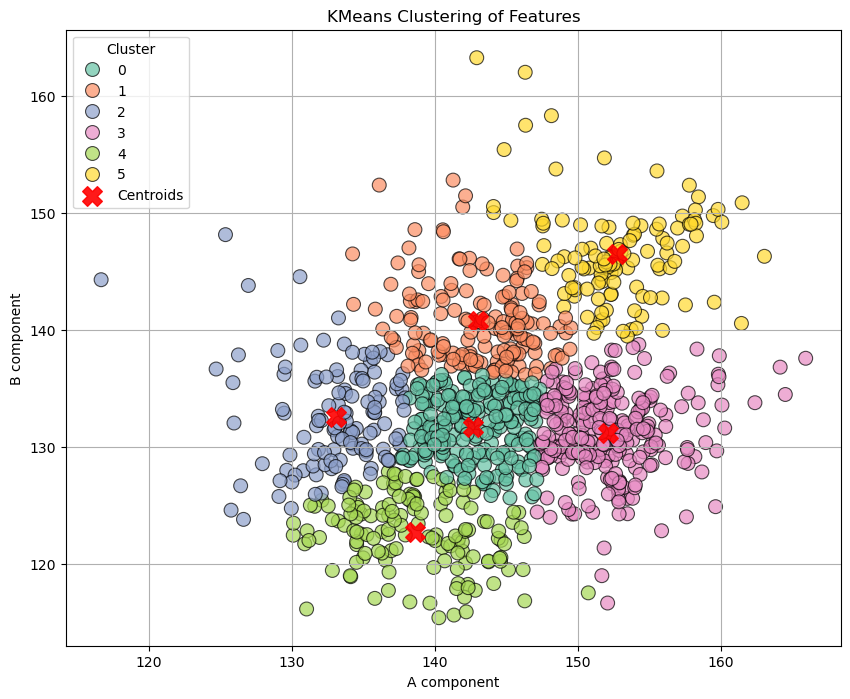

In [36]:
centers = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x='A',
    y='B',
    hue='cluster',
    palette='Set2',
    s=100,
    edgecolor='k',
    alpha=0.7
)

# Plot the cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c='red',
    s=200,
    alpha=0.9,
    marker='X',
    label='Centroids'
)

# Customize the plot
plt.title('KMeans Clustering of Features')
plt.xlabel('A component')
plt.ylabel('B component')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()

In [37]:
# Using distance-based outlier detection
from sklearn.neighbors import LocalOutlierFactor

# Initialize and fit LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_labels = lof.fit_predict(X)

# Get indices of outliers
outlier_indices = np.where(outlier_labels == -1)[0]

# Print number of outliers found
print(f"Number of outliers detected: {len(outlier_indices)}")

Number of outliers detected: 106


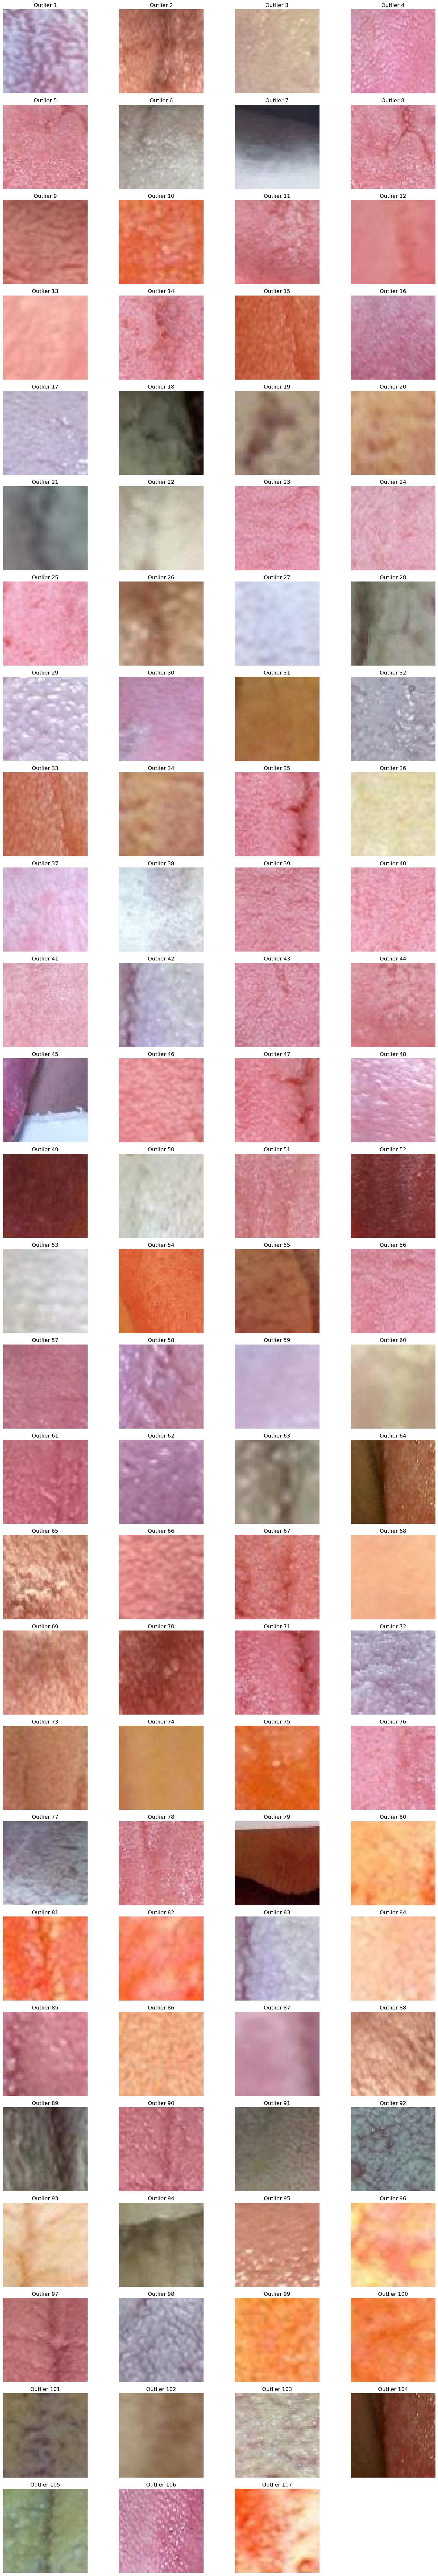

In [23]:
# Create a function to display outlier images
def display_outliers(data, outlier_indices, num_cols=4):
    num_images = len(outlier_indices)
    num_rows = (num_images + num_cols - 1) // num_cols
    
    plt.figure(figsize=(15, 3*num_rows))
    
    for idx, outlier_idx in enumerate(outlier_indices):
        img = cv2.imread('../dataset_cropped/all/' + data[outlier_idx])
        img = np.array(img)
        plt.subplot(num_rows, num_cols, idx + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'Outlier {idx+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Assuming you have outlier indices stored in a variable called 'outlier_indices'
# and your image data in 'image_data'
display_outliers(images, outlier_indices)


In [38]:
cluster_means = df.groupby('cluster')[['A', 'B']].mean().reset_index()
cluster_max = df.groupby('cluster')[['A', 'B']].max().reset_index()
cluster_min = df.groupby('cluster')[['A', 'B']].min().reset_index()

In [39]:
cluster_means.columns = ['cluster', 'A_mean', 'B_mean']
cluster_max.columns = ['cluster', 'A_max', 'B_max']
cluster_min.columns = ['cluster', 'A_min', 'B_min']

In [40]:
combined_cluster_df = pd.merge(cluster_means, cluster_max, on='cluster')
combined_cluster_df = pd.merge(combined_cluster_df, cluster_min, on='cluster')

In [41]:
combined_cluster_df

,cluster,A_mean,B_mean,A_max,B_max,A_min,B_min
0,0,142.698130,131.688881,147.355713,136.196045,137.669922,125.626221
1,1,143.044138,140.733301,149.526123,152.829834,134.263428,136.166748
2,2,133.098079,132.538465,137.937988,148.163086,116.688721,123.791016
3,3,152.121059,131.204186,165.933838,138.760498,147.168945,116.631104
4,4,138.637320,122.704214,150.739258,127.862061,130.116699,115.373291
5,5,152.773948,146.506692,163.050049,163.305664,142.941650,139.480957


In [42]:
def lab_to_rgb(l, a, b):
    # Create a 1x1 LAB image
    lab_color = np.uint8([[[l, a, b]]])
    # Convert LAB to BGR
    bgr_color = cv2.cvtColor(lab_color, cv2.COLOR_LAB2BGR)
    # Convert BGR to RGB
    rgb_color = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2RGB)
    # Flatten the array
    rgb_color = rgb_color.flatten()
    return rgb_color

In [43]:
cluster_means_rgb = combined_cluster_df.apply(lambda x: lab_to_rgb(x['A_mean'], x['B_mean'], overall_L_mean), axis=1)
cluster_max_rgb = combined_cluster_df.apply(lambda x: lab_to_rgb(x['A_max'], x['B_max'], overall_L_mean), axis=1)
cluster_min_rgb = combined_cluster_df.apply(lambda x: lab_to_rgb(x['A_min'], x['B_min'], overall_L_mean), axis=1)

combined_cluster_df['RGB_mean'] = cluster_means_rgb
combined_cluster_df['RGB_max'] = cluster_max_rgb
combined_cluster_df['RGB_min'] = cluster_min_rgb

In [44]:
cluster_colors = []

for _, row in cluster_means.iterrows():
    l_mean = overall_L_mean
    a_mean = row['A_mean']
    b_mean = row['B_mean']
    rgb_color = lab_to_rgb(l_mean, a_mean, b_mean)
    cluster_colors.append(rgb_color)

# Image Saving

In [45]:
# Save images to cluster directories
def copy_images_to_clusters(df, base_output_dir):
    import shutil
    import os

    print(f"Base output directory: {base_output_dir}")
    os.makedirs(base_output_dir, exist_ok=True)

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Copying images"):
        source_path = row['filename']
        cluster = row['cluster']
        
        cluster_dir = os.path.join(base_output_dir, f"cluster_{cluster}")
        os.makedirs(cluster_dir, exist_ok=True)
        
        filename = os.path.basename(source_path)
        dest_path = os.path.join(cluster_dir, filename)
        
        try:
            shutil.copy2(source_path, dest_path)
        except Exception as e:
            print(f"Error copying file: {e}")

In [46]:
base_output_dir = f"clusters/coating_no_oversaturated/{num_clusters}-clusters"
copy_images_to_clusters(df, base_output_dir)

Base output directory: clusters/coating_no_oversaturated/6-clusters


Copying images: 100%|██████████| 1055/1055 [00:01<00:00, 866.18it/s]
